In [15]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from ipywidgets import widgets, VBox, HBox, Button, Output, Layout
from IPython.display import display, clear_output
import pandas as pd
from math import *
np.random.seed(42)

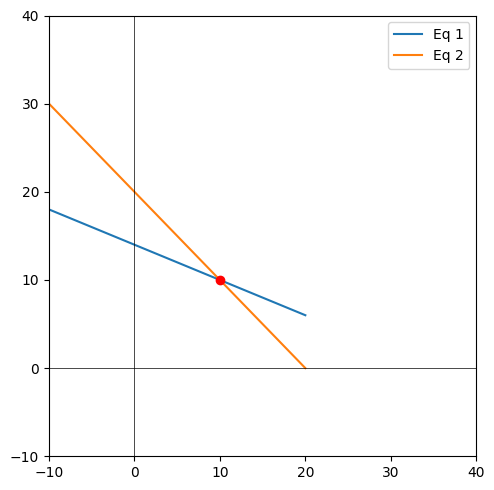

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output


class NotebookLinearSolver:
    def __init__(self):
        self.equations = []
        self.third_eq_enabled = False
        self.default_eqs = [
            [20, 50, 700],
            [1, 1, 20],
            [50, 20, 700]
        ]
        self.create_ui()
        self.update_plot()

    def create_ui(self):
        self.eq_boxes = []

        # Create initial 2 equations
        for i in range(2):
            self.eq_boxes.append(self.make_eq_row(i))

        # Toggle third equation
        self.toggle_btn = widgets.ToggleButton(
            value=False,
            description='[+]',
            tooltip='Toggle third equation',
            layout=widgets.Layout(width='50px')
        )
        self.toggle_btn.observe(self.toggle_third_eq, names='value')

        # Output for matrix + solution
        self.output = widgets.Output()

        # Display all widgets
        ui = widgets.VBox(self.eq_boxes + [self.toggle_btn, self.output])
        display(ui)

        # Set up plot
        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        plt.tight_layout()

    def make_eq_row(self, idx):
        a = widgets.Text(value=str(self.default_eqs[idx][0]), placeholder='a', layout=widgets.Layout(width='60px'))
        c = widgets.Text(value=str(self.default_eqs[idx][1]), placeholder='c', layout=widgets.Layout(width='60px'))
        b = widgets.Text(value=str(self.default_eqs[idx][2]), placeholder='b', layout=widgets.Layout(width='60px'))
        for box in (a, c, b):
            box.observe(lambda change: self.update_plot(), names='value')

        row = widgets.HBox([
            a, widgets.Label("c +"),
            c, widgets.Label("t ="),
            b
        ])
        row._entry_widgets = [a, c, b]
        return row

    def toggle_third_eq(self, change):
        if change['new']:
            self.third_eq_enabled = True
            row = self.make_eq_row(2)
            self.eq_boxes.insert(2, row)
            self.toggle_btn.description = '[-]'
        else:
            self.third_eq_enabled = False
            self.eq_boxes.pop(2)
            self.toggle_btn.description = '[+]'

        with self.output:
            clear_output()
        self.update_plot()

    def get_equations(self):
        A = []
        b = []
        for row in self.eq_boxes:
            entries = row._entry_widgets
            try:
                a = float(entries[0].value) if entries[0].value.strip() else 1.0
                c = float(entries[1].value) if entries[1].value.strip() else 1.0
                b_ = float(entries[2].value) if entries[2].value.strip() else 1.0
                A.append([a, c])
                b.append(b_)
            except ValueError:
                continue
        return np.array(A), np.array(b)

    def update_plot(self):
        A, b = self.get_equations()
        self.ax.clear()

        if len(A) < 2:
            self.ax.set_title("Enter at least 2 equations")
            self.fig.canvas.draw()
            return

        x_vals = np.linspace(-20, 20, 400)
        for i in range(len(A)):
            a, c = A[i]
            rhs = b[i]
            if c != 0:
                y_vals = (rhs - a * x_vals) / c
                self.ax.plot(x_vals, y_vals, label=f"Eq {i+1}")
            elif a != 0:
                self.ax.axvline(x=rhs / a, label=f"Eq {i+1}")
            else:
                self.ax.axhline(y=rhs, label=f"Eq {i+1}")

        self.ax.set_xlim(-10, 40)
        self.ax.set_ylim(-10, 40)
        self.ax.axhline(0, color='black', lw=0.5)
        self.ax.axvline(0, color='black', lw=0.5)

        with self.output:
            clear_output()
            try:
                sol = np.linalg.solve(A, b)
                self.ax.plot(*sol, 'ro')
                msg = f"Exact solution: c = {sol[0]:.2f}, t = {sol[1]:.2f}"
            except np.linalg.LinAlgError:
                try:
                    sol, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
                    msg = f"No exact solution.\nLeast squares: c = {sol[0]:.2f}, t = {sol[1]:.2f}"
                    self.ax.plot(*sol, 'ro')
                except:
                    msg = "Could not solve system."

            try:
                cond = np.linalg.cond(A)
                msg += f"\nCondition number: {cond:.2e}"
            except:
                msg += "\nCondition number: N/A"

            matrix_str = "     A         x    =  b\n"
            for i in range(A.shape[0]):
                a_str = f"[{A[i,0]:>4.0f} {A[i,1]:>4.0f}]"
                x_str = "[c]" if i == 0 else "[t]" if i == 1 else "   "
                b_str = f"[{b[i]:>5.0f}]"
                matrix_str += f"{a_str}   {x_str}   {b_str}\n"

            print(matrix_str)
            print(msg)

        self.ax.legend()
        self.fig.canvas.draw()

# 🔁 Run the UI in the notebook
NotebookLinearSolver()
